# R laboratory exercises 03
### Laboratory session: April 14, 2021
### Exercises due on: May 2, 2021

#### Samuele Piccinelli, 2027650
#### samuele.piccinelli@studenti.unipd.it

In [1]:
# import libraries and useful dependencies
library(ggplot2)
library(latex2exp)
library(data.table)
suppressMessages(library(purrr)) # suppress warnings of masked objects
suppressMessages(library(dplyr))
# plot settings
theme_set(theme_bw() + theme(text=element_text(family='Times New Roman', size=12), legend.text=element_text(size=12)))

#### Exercise 1
The triangular distribution, in the interval $[a, b]$, is given by the following:
$$f(x)=\begin{cases} 
      \frac{2(x-a)}{(b-a)(c-a)} & a \leq x < c  \\
      \frac{2(b-x)}{(b-a)(b-c)} & c \leq x \leq b \\
      0 & \mathrm{otherwise}
   \end{cases}$$
where $c\in [a, b]$.
1. Plot the function, given the interval $[a, b]$.
2. Write an algorithm to generate random numbers from the triangular distribution.
3. Generate $10^4$ random numbers from the distribution, show them in an histogram and superimpose the analytical curve.

***
Let $\chi_A(x)$ be the indicator function over the set $A$ defined as 
$$\chi_A(x)=\begin{cases} 
      1 & \mathrm{if}\ x\in A  \\
      0 & \mathrm{otherwise}
   \end{cases}$$
then $$f(x) = f_1(x) \chi_{[a,c)}(x) + f_2(x) \chi_{[c,b]}(x)$$
where $f_1(x) = \frac{2(x-a)}{(b-a)(c-a)}$ and $f_2(x) = \frac{2(b-x)}{(b-a)(b-c)}$. By integrating over $x$ one obtains the cumulative distribution function:
$$F(x)=\begin{cases}
      0 & x < a \\
      \frac{(x-a)^2}{(a-b)(a-c)} & a \leq x < c  \\
      \frac{(c-x)(2b-c-x)}{(a-b)(b-c)} & c \leq x \leq b \\
      1 & x > b
   \end{cases}$$
By multiplying and dividing both factors of the piecewise defined _pdf_ $f(x)$ by a factor $2$ the indexes for the composition sampling method are set to $$p_1 = p_2 = 1/2$$.

In [2]:
dtri <- function(x){
    f1 <- 2*(x-a)/((b-a)*(c-a))
    f2 <- 2*(b-x)/((b-a)*(b-c))
    pdf <- ifelse((a<=x & x<c), f1, ifelse(c<=x & x<=b, f2, 0))}

quad <- function(const){
    c1 <- -2*b; c0 <- 2*b*c-c**2-0.5*const*(a-b)*(b-c) # define grade 1 and 0 terms
    delta <- c1**2-4*c0
    roots <- c((-c1 + sqrt(delta))/(2), (-c1 - sqrt(delta))/(2))
    x <- roots[c<=roots & roots<=b] # by solving for x, the values outside c <= x <= b are rejected
    return(x)}

rtri <- function(n){
    u1 <- runif(n); u2 <- runif(n)
    roots1 <- sqrt(0.5*u2*(a-b)*(a-c)) + a
    roots1 <- roots1[a<=roots1 & roots1<c]
    roots2 <- as.numeric(sapply(u2, quad, simplify=TRUE))

    return(ifelse(u1<0.5, roots1, roots2))}

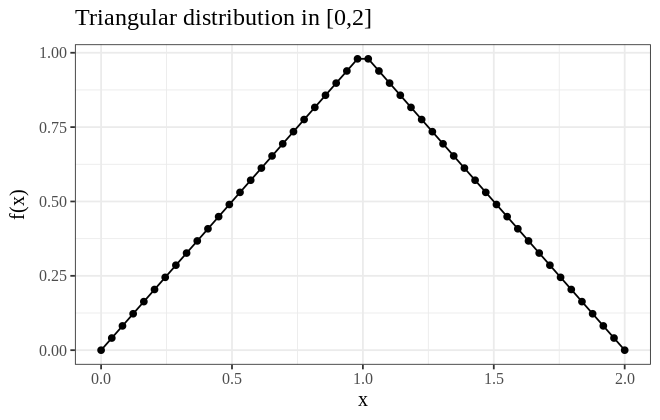

In [3]:
a <- 0; b <- 2; c <- 1

x <- seq(0,2,length.out=50)
pdf <- data.frame('pdf' = dtri(x), 'x' = x)
options(repr.plot.width=5.5, repr.plot.height=3.5)
ggplot(pdf, aes(x=x, y=pdf)) + geom_point() + geom_line() +
labs(title=TeX('Triangular distribution in $\\[0,2\\]$'), y=TeX('$f(x)'))

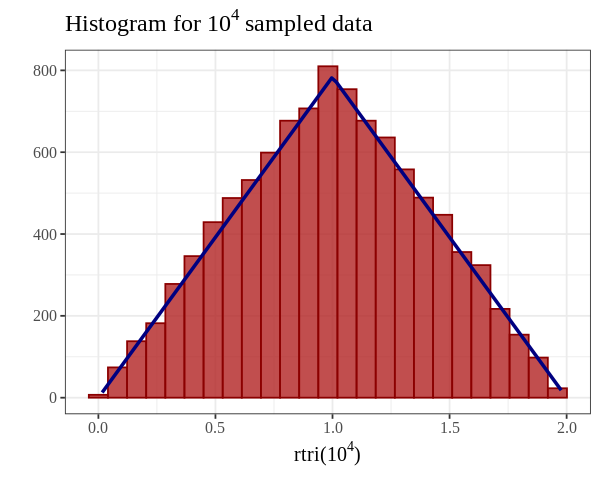

In [4]:
n <- 10000
data <- rtri(n)
bins <- 25
# in order to superimpose the pdf to the histogram, a multiplicative factor has to be taken into account
fact <- n*(max(data)-min(data))/bins
triangular <- data.frame('triangular' = data)

options(repr.plot.width=5, repr.plot.height=4)
ggplot(triangular, aes(x=triangular)) +
geom_histogram(bins=bins, color='darkred', fill='firebrick', alpha=0.8) +
labs(title=TeX('Histogram for $10^4$ sampled data'), x=TeX('rtri($10^4$)'), y='') +
stat_function(fun = function(x) {fact*dtri(x)}, color = 'navy', size=1)

#### Exercise 2: Markov's Inequality
Markov's inequality represents an upper bound to probability distributions:
$$P(X\geq k) \leq \frac{E[X]}{k} \text{for } k>0$$
Having defined a function
$$G(k) = 1-F(k)\equiv P(X\geq k)$$
plot $G(k)$ and the Markov's upper bound for
1. The exponential, $Exp(\lambda = 1)$, distribution function.
2. The uniform, $\mathcal{U}(3, 5)$, distribution function.
3. The binomial, $Bin(n = 1, p = 1/2)$, distribution function.
4. a Poisson, $Pois(\lambda = 1/2)$, distribution function.

In [5]:
build_df <- function(k, func, mrk.ineq){ # build dataframe
    df <- rbind(data.frame('k'=k, 'G'=func, 'type'='prob'), data.frame('k'=k, 'G'=mrk.ineq, 'type'='mrk'))
    return(df)}

plot_mrk_ineq <- function(data, title){ # plot G(k) and E[X]/k
    plt <- ggplot(data, aes(k, G, col=type, group=type)) + geom_point(size=1) + geom_line() +
    labs(title=TeX(title), x=TeX('$k$'), y='', col='') +
    scale_color_manual(breaks=c('mrk', 'prob'), labels=c('E[X]/k', 'G(k)'), values=c('red', 'blue'))
    return(plt)}

In [6]:
# exponential
k <- seq(0.5,4,length.out=50)
lambda <- 1
E.x = 1/lambda
mrk.ineq <- E.x/k
markov_exp <- build_df(k, 1-pexp(k,rate=lambda), mrk.ineq)
plt_exp <- plot_mrk_ineq(markov_exp, 'M. upper bound for $Exp(\\lambda = 1)$')
# uniform
k <- seq(2,6,length.out=50)
a <- 3; b <- 5
E.x <- (a+b)/2
mrk.ineq <- E.x/k
markov_unif <- build_df(k, 1-punif(k,a,b), mrk.ineq)
plt_unif <- plot_mrk_ineq(markov_unif, 'M. upper bound for $Unif(3,5)$')
# binomial
k <- seq(0.3,2,length.out=50)
n <- 1; p <- 0.5
E.x <- n*p
mrk.ineq <- E.x/k
markov_binom <- build_df(k, 1-pbinom(k,n,p), mrk.ineq)
plt_binom <- plot_mrk_ineq(markov_binom, 'M. upper bound for $Binom(1,0.5)$')
# poisson
k <- seq(0.5,4,length.out=50)
lambda <- 0.5
E.x <- lambda
mrk.ineq <- E.x/k
markov_pois <- build_df(k, 1-ppois(k,lambda=lambda), mrk.ineq)
plt_pois <- plot_mrk_ineq(markov_pois, 'M. upper bound for $Pois(\\lambda = 0.5)$')

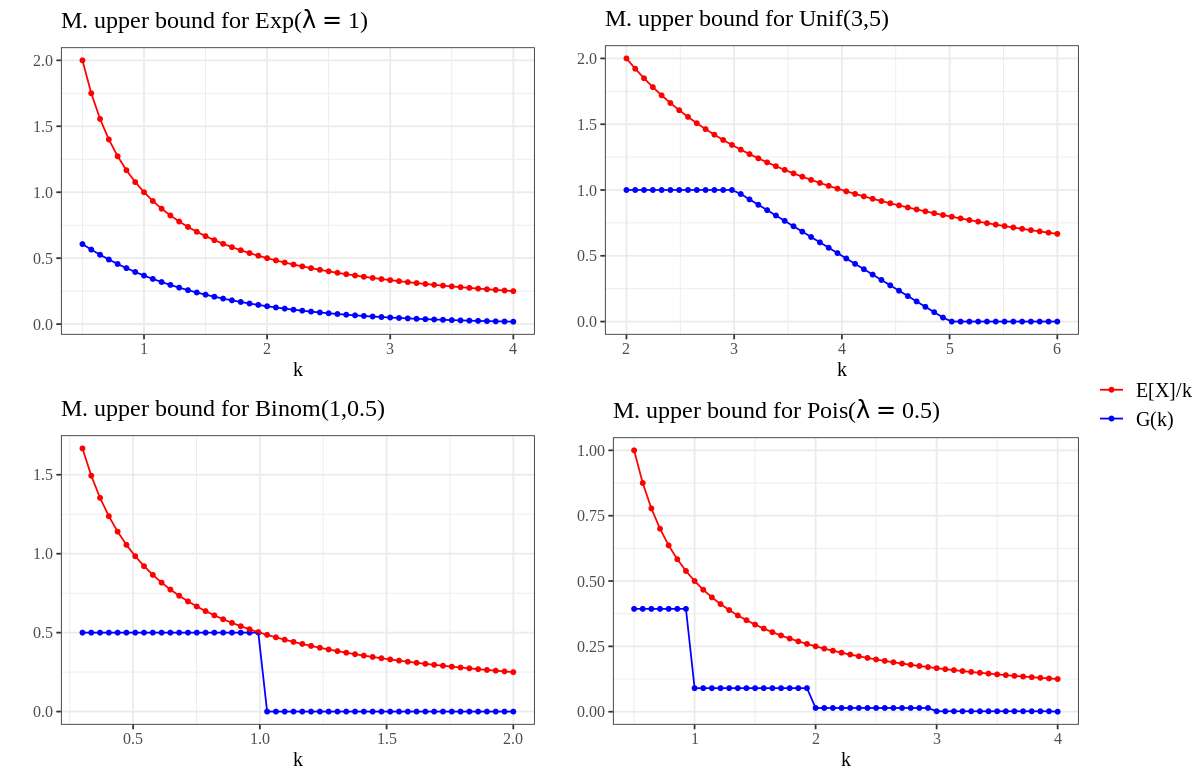

In [7]:
options(repr.plot.width=10, repr.plot.height=6.5)
lemon::grid_arrange_shared_legend(plt_exp, plt_unif, plt_binom, plt_pois, ncol = 2, nrow = 2, position='right')

#### Exercise 3: Chebyshev's inequality
Chebyshev's inequality tells us that
$$P(|X-\mu|\geq k\sigma)\leq \frac{1}{k^2}$$
which can also be written as
$$P(|X-\mu|< k\sigma)\geq 1-\frac{1}{k^2}$$
Use _R_ to show, with a plot, that Chebyshev's inequality is is an upper bound to the following distributions:
1. A normal distribution, $\mathcal{N}(\mu = 3,\sigma = 5)$.
2. An exponential distribution, $Exp(\lambda = 1)$.
3. A uniform distribution $\mathcal{U}(1-\sqrt{2},1+\sqrt{2})$.

4. A Poisson, $Pois(\lambda = 1/3)$, distribution function.

***
In the plots below the complementary formula for Chebyshev's inequality is used:
$$P(|X-\mu|< k\sigma) \geq 1-\frac{1}{k^2}\implies G(k) \geq 1-\frac{1}{k^2}$$
where $G(k) = F(X < \mu+k\sigma) - F(X < \mu-k\sigma)$ and $F$ is the cumulative distribution function.

For continuous distributions $F(X\leq x)=F(X< x)$ since the first differs from the latter by a set of measure $0$; below we approximate $F(X\leq x) \approx F(X< x)$ since the difference is negligible in case of discrete but highly populated distributions.

In [8]:
x <- seq(0,6,length.out=50)
k <- seq(1,6,length.out=50)
chb.ineq <- 1 - 1/k^2

In [9]:
# normal
mu <- 3; sigma <- 5
p.norm <- pnorm(mu+x*sigma,mu,sigma)-pnorm(mu-x*sigma,mu,sigma)
# exponential
lambda <- 1;
mu <- 1/lambda; sigma <- 1/lambda # var(x) = 1/lamda^2
p.exp <- pexp(mu+x*sigma,lambda)-pexp(mu-x*sigma,lambda)
# uniform
a <- 1-sqrt(2); b <- 1+sqrt(2)
mu <- (a+b)/2; sigma <- (b-a)/(2*sqrt(3))
p.unif <- punif(mu+x*sigma,a,b)-punif(mu-x*sigma,a,b)
# poisson
lambda <- 1/3
mu <- lambda; sigma <- sqrt(lambda)
p.pois <- ppois(mu+x*sigma,lambda)-ppois(mu-x*sigma,lambda)

pdfs <- data.frame('x'=x,'p.norm'=p.norm,'p.exp'=p.exp,'p.unif'=p.unif,'p.pois'=p.pois)
chebyshev <- data.frame('k'=k,'chb.ineq'=chb.ineq)
pdfs <- reshape2::melt(pdfs, id.vars='x') # reshape to plot

The plots below show <font color='red'>Chebyshev's lower bound</font> with $4$ different <font color='blue'>probability density functions</font>.

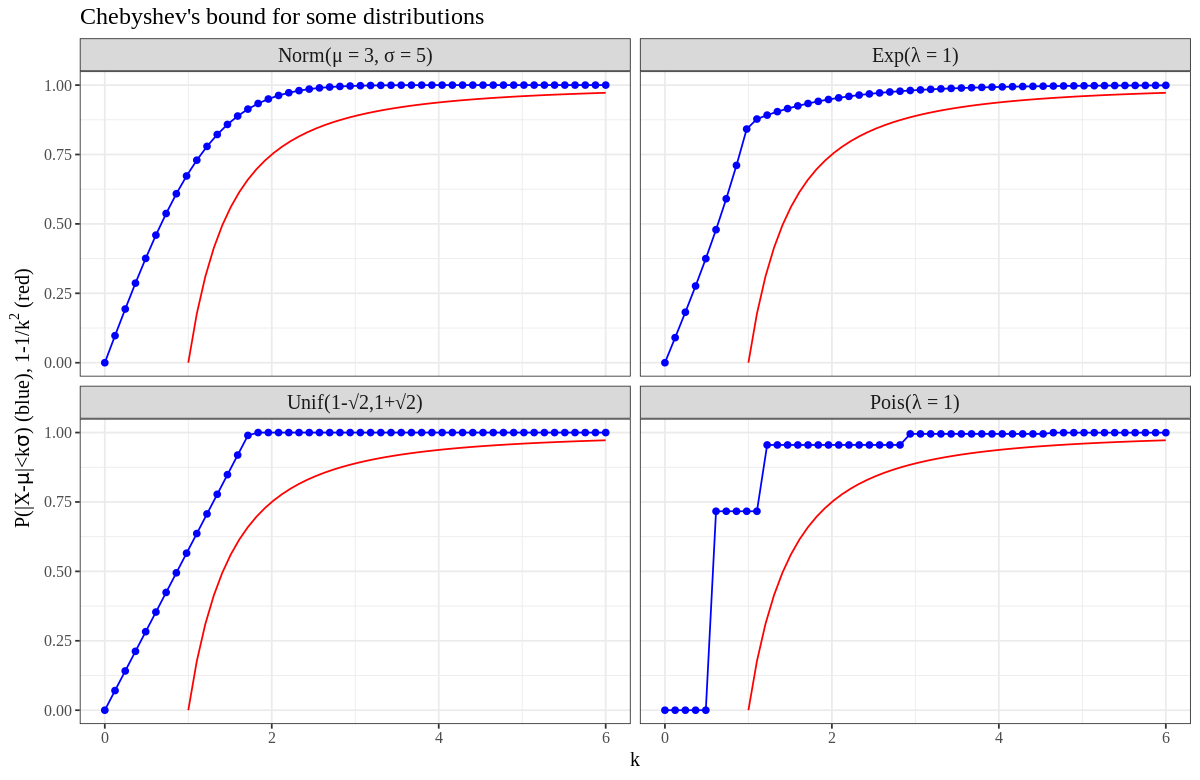

In [10]:
names <- c('p.norm'='Norm(μ = 3, σ = 5)','p.exp'='Exp(λ = 1)', 'p.unif'='Unif(1-√2,1+√2)','p.pois'='Pois(λ = 1)')
ggplot(pdfs, aes(x, value)) + geom_line(size=0.5, col='blue') + geom_point(col='blue') +
facet_wrap(~variable, labeller=labeller(variable=names)) + geom_line(aes(x=k, y = chb.ineq), data = chebyshev, colour = 'red') +
labs(title='Chebyshev\'s bound for some distributions', x=TeX('$k$'),
     y=TeX('$P(|X-\\mu | < k\\sigma)$ (blue), $1-1/k^2$ (red)')) + theme(strip.text = element_text(size=12))

#### Exercise 4 - Community Mobility Open Data
Community Mobility Reports have been created with the aim to provide insights into what has changed in response to policies aimed at combating COVID-19. Data can be found at https://www.google.com/covid19/mobility/.

Download and analyze the following data sets:
1. https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv<br>
and
2. https://www.gstatic.com/covid19/mobility/Region_Mobility_Report_CSVs.zip

The data show how visitors to (or time spent in) categorized places change compared to baseline days. A baseline day represents a normal value for that day of the week. The baseline day is the median value from the 5-week period Jan 3 - Feb 6, 2020.
To make the reports useful, categories have been used to group some of the places with similar characteristics for purposes of social distancing guidance. The following categories are available:
- `retail_and_recreation`, i.e. places like restaurants,cafes, shopping centers, theme parks,museums, libraries, and movie theaters.
- `grocery_and_pharmacy`, i.e. grocery markets, food warehouses, farmers markets, specialty food shops, drug stores, and pharmacies.
- `parks`, i.e. national parks, public beaches, marinas, dog parks, plazas,and public gardens.
- `transit_stations` i.e. all public transport hubs such as subway, bus, and train stations.
- `workplaces`, i.e. places of work.
- `residential`, i.e. people's residence.

Select a couple of European countries of your choice and analyze the trends in the previous variables over time: produce a plot of the data by averaging the observable over a period of one week (hint: convert the `date` field to `lubridate::week`) and one month and quantify the impact of COVID-19 restrictions on mobility stations.

In [11]:
readcsv <- function(year, country){ # given year and country, load dataset
    filename <- paste0( year, '_', country, '_Region_Mobility_Report.csv')
    mobdata_dir <- 'data/Region_Mobility_Report_CSVs'
    filepath <- file.path(mobdata_dir, filename)
    message(paste('Reading from file:', filepath))
    read.csv(filepath)}

clean_df <- function(df){ # clean data: drop useless data and rename columns
    data <- df[,-(1:8)]
    colnames(data) <- colnames(data) %>% stringr::str_remove('_percent_change_from_baseline') %>%
                      stringr::str_replace_all('_', ' ')
    return(data)}

weekly_avg <- function(data){ # WEEKLY AVERAGE
    # date -> week, group by week, compute mean over all columns and ignore NA
    weekly_avg <- data %>% mutate(date = week(date)) %>% group_by(date) %>% summarize_all(mean, na.rm=TRUE)
    weekly_avg <- reshape2::melt(weekly_avg, id.vars='date')} # reshape to plot

monthly_avg <- function(data){ # MONTLY AVERAGE
    monthly_avg <- data %>% mutate(date = lubridate::month(date,label=TRUE)) %>% # month label instead of number
                   group_by(date) %>% summarize_all(mean, na.rm=TRUE)
    monthly_avg <- reshape2::melt(monthly_avg, id.vars='date')}

plot_weekly <- function(data, title){ # plot weekly graphs
    plt <- ggplot(data, aes(date, value, col=value)) + geom_line(size=0.5) + geom_point() +
    facet_wrap(~variable) + labs(title=title, x='# week', y='% change from baseline', col='% change') +
    geom_hline(yintercept=0, linetype='dashed', color='red') +
    theme(strip.text = element_text(size=15)) + scale_color_gradient(low = 'blue', high = 'red')
    return(plt)}

plot_monthly <- function(data, title){ # plot monthly graphs
    plt <- ggplot(data, aes(date, value, col=value)) + geom_line(group = 1, size=0.5) + geom_point() +
    facet_wrap(~variable) + labs(title=title, x='month', y='% change from baseline', col='% change') +
    geom_hline(yintercept=0, linetype='dashed', color='red') +
    theme(strip.text = element_text(size=15)) + scale_color_gradient(low = 'darkgreen', high = 'yellow')
    return(plt)}

In [12]:
# ITALY
year <- 2020; country <- 'IT'
italy <- map_df(year, readcsv, country) # load dataset
data_italy <- clean_df(italy) # drop useless data and rename columns

weekly_avg_italy <- weekly_avg(data_italy) # averaging the observables over a period of one week
monthly_avg_italy <- monthly_avg(data_italy) # averaging the observables over a period of one month

# GERMANY
country <- 'DE'
germany <- map_df(year, readcsv, country)
data_germany <- clean_df(germany)

weekly_avg_germany <- weekly_avg(data_germany)
monthly_avg_germany <- monthly_avg(data_germany)

Reading from file: data/Region_Mobility_Report_CSVs/2020_IT_Region_Mobility_Report.csv
Reading from file: data/Region_Mobility_Report_CSVs/2020_DE_Region_Mobility_Report.csv


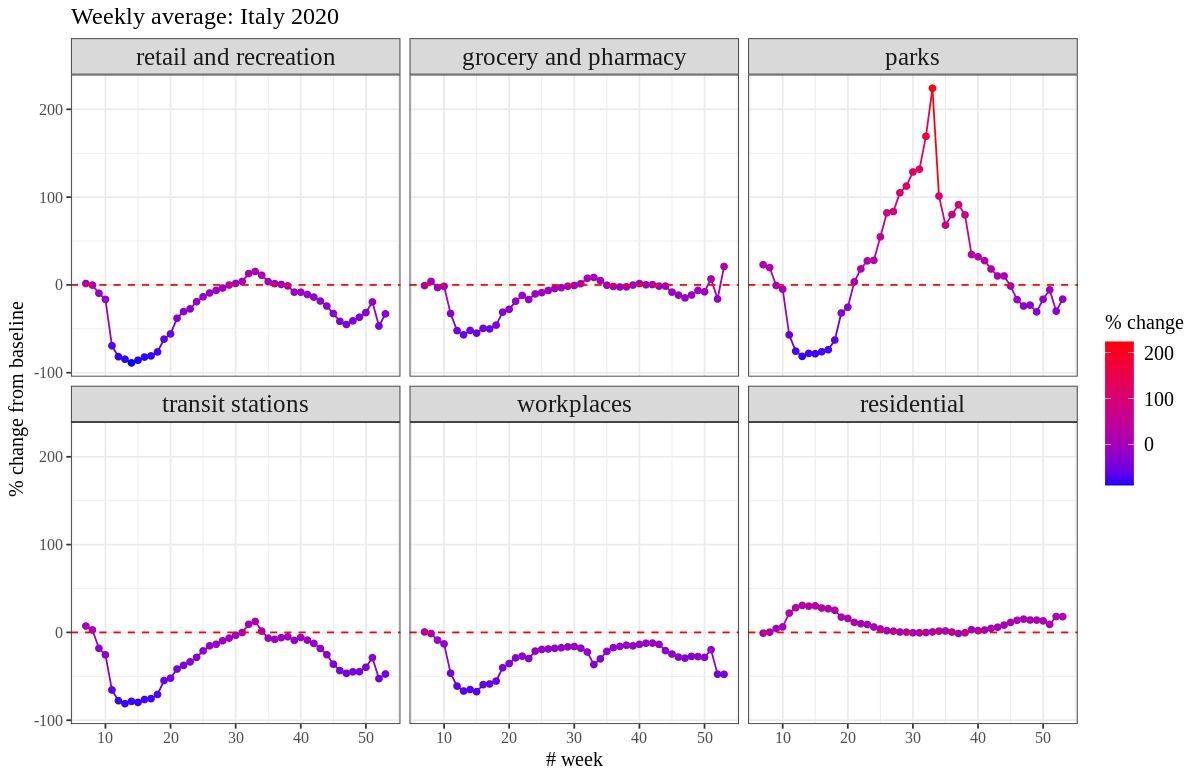

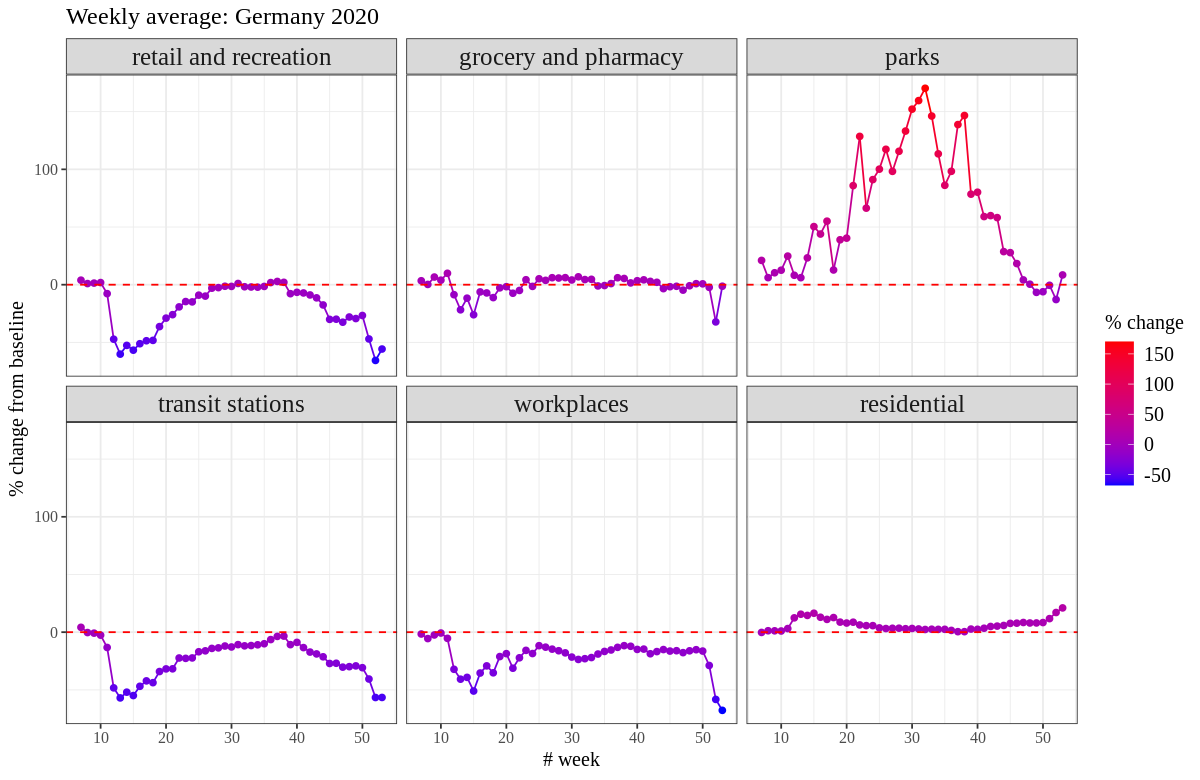

In [13]:
plot_weekly(weekly_avg_italy,'Weekly average: Italy 2020') # plot results
plot_weekly(weekly_avg_germany,'Weekly average: Germany 2020')

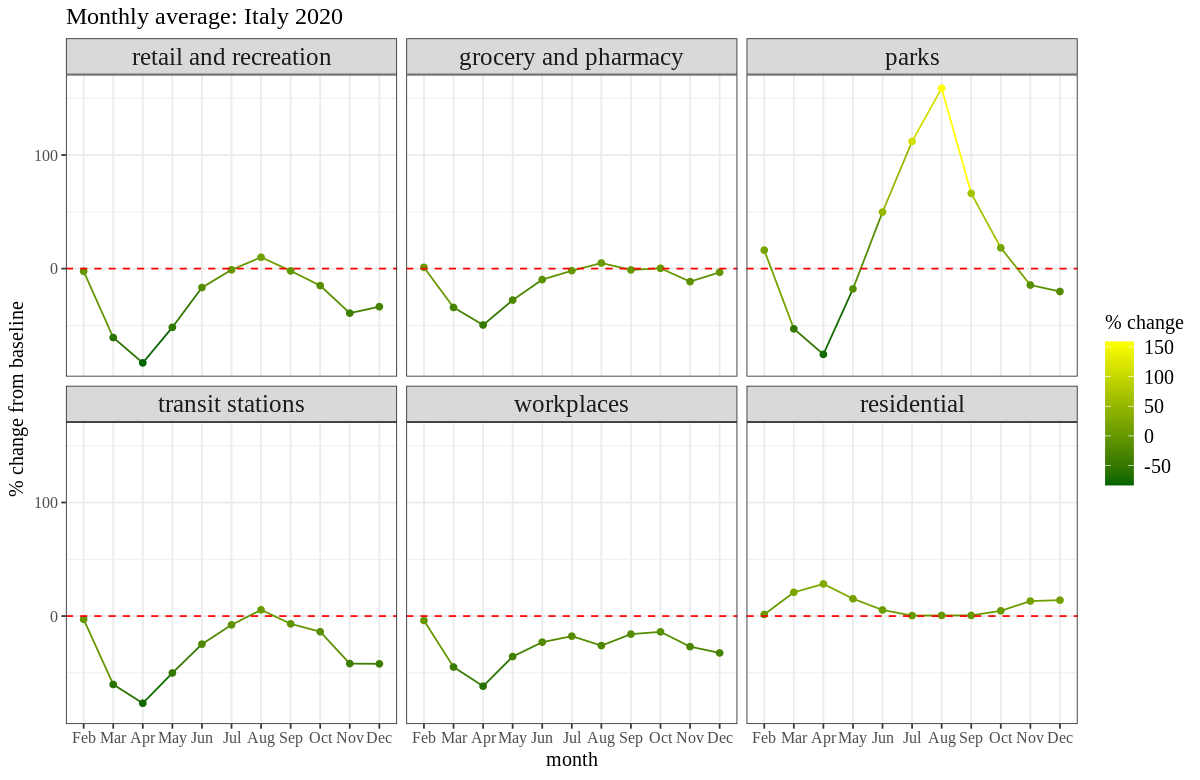

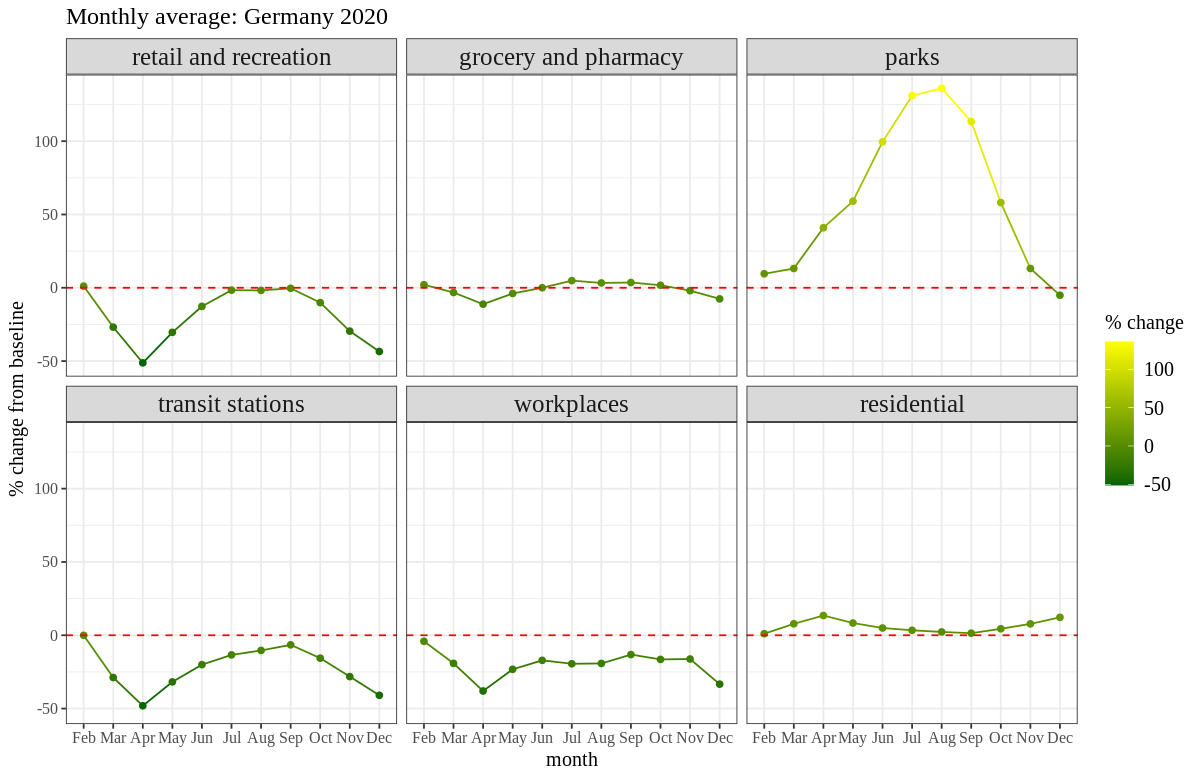

In [14]:
plot_monthly(monthly_avg_italy,'Monthly average: Italy 2020')
plot_monthly(monthly_avg_germany,'Monthly average: Germany 2020')

In [15]:
monthly_changes_italy <- monthly_avg_italy[monthly_avg_italy$variable=='transit stations',]$value
monthly_changes_germany <- monthly_avg_germany[monthly_avg_germany$variable=='transit stations',]$value
cat('The % change from the baseline value from Feb to Dec 2020 for transit stations was',
    round(mean(monthly_changes_italy),2),'% for Italy and', round(mean(monthly_changes_germany),2), '% for Germany')

The % change from the baseline value from Feb to Dec 2020 for transit stations was -29.23 % for Italy and -22.18 % for Germany

The impact of the pandemic over transport stations has been definitely negative, with an average percentage difference from the baseline from February to December 2020 of $\sim -22\%$ and $\sim -30\%$ for Germany and Italy respectively.<br>
The biggest decrease was seen in April ($\sim-60\%$ for I. and $\sim-50\%$ for G.): the trend was from that point on steadily quasi-linear, until September where it reached almost pre-COVID levels in G. and topped the baseline in I. With the arrive of the fall it started to decrease again: overall it can be observed that the curve in G. experienced a tighter range of change (i.e. was generally more "consistent" with the pace of the restrictions).
***
For both Italy and Germany the trend of the observed variables is similar, indicating a comparable response of the two countries to the COVID-19 pandemic.

What stands out is the drastic decrease in activity of recreation activities, stations (as stated above) and workplaces in April ($\sim +50\%$ for both countries with respect to the baseline days) and the sudden growth of the park curve in Italy (up to a whopping $\sim +200\%$ in August). The latter has remained constant at the beginning of the year (probabily due to the winter season) and drove up in correspondance of the lifting of the restrictions. In Germany the growth was more mild, reaching $\sim+150\%$ at the top of the season: this can be seen also in the more bell-shaped curve in the monthly plots with respect to the peaked curve in Italy.